In [42]:
from Functions import calc_supply, convert_gwh, downsample_df, set_timeIndex, test_stationarity, gridsearch_sarima, gridsearch_arima,nn_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import holidays
import itertools


#ARIMAX Models packages
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

#GARCH Model Package
from arch import arch_model

#Neural Network packages
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from keras.regularizers import l2

In [43]:
df_cons = pd.read_excel('datasets/Actual_consumption_201901010000_202011302359.xlsx', skiprows=6,na_values='-')
df_price = pd.read_excel('datasets/Day-ahead_prices_201901010000_202011302359.xlsx', skiprows=6, na_values='-')
df_gen = pd.read_excel('datasets/Actual_generation_201901010000_202011302359.xlsx', skiprows=6, na_values='-')

df_test = pd.read_excel('datasets/Day-ahead_prices_202012010000_202012312359.xlsx', skiprows=6, na_values='-')
df_test_cons = pd.read_excel('datasets/Actual_consumption_202012010000_202012312359.xlsx', skiprows=6, na_values='-')
df_test_gen = pd.read_excel('datasets/Actual_generation_202012010000_202012312359.xlsx', skiprows=6, na_values='-')

df_price = df_price.append(pd.read_excel('datasets/Day-ahead_prices_201712010000_201812312359.xlsx', skiprows=6,na_values='-'))
df_cons = df_cons.append(pd.read_excel('datasets/Actual_consumption_201712010000_201812312359.xlsx', skiprows=6,na_values='-'))
df_gen = df_gen.append(pd.read_excel('datasets/Actual_generation_201712010000_201812312359.xlsx', skiprows=6,na_values='-'))

In [44]:
df_cons = set_timeIndex(df_cons) 
df_test_cons =  set_timeIndex(df_test_cons)
df_gen = set_timeIndex(df_gen)
df_test_gen  = set_timeIndex(df_test_gen)
df_price = set_timeIndex(df_price)
df_test = set_timeIndex(df_test)

In [45]:
#Convert to GWh for better Visualization
df_cons['Total[MWh]']/=1000
df_cons.rename(columns={'Total[MWh]': 'TotalConsumption[GWh]'}, inplace=True)

#Convert to GWh for better Visualization
df_test_cons['Total[MWh]']/=1000
df_test_cons.rename(columns={'Total[MWh]': 'TotalConsumption[GWh]'}, inplace=True)

#Drop unused columns
df_price.drop(df_price.columns[[2,3,4,5,6,7,8,9,10,11,12,13]], axis=1, inplace=True)

#Remove Market Signals
df_price = df_price[~df_price.index.duplicated(keep='first')]
df_price = df_price[df_price['Germany/Luxembourg[€/MWh]'] > 1]

#Drop unused columns
df_test.drop(df_test.columns[[2,3,4,5,6,7,8,9,10,11,12,13]], axis=1, inplace=True)

#Remove Market Signals
df_test = df_test[df_test['Germany/Luxembourg[€/MWh]'] > 1]

df_gen = calc_supply(df_gen)
df_test_gen = calc_supply(df_test_gen)
df_gen = convert_gwh(df_gen)
df_test_gen = convert_gwh(df_test_gen)
 
df_cons = downsample_df(df_cons)  
df_gen = downsample_df(df_gen)  
df_price = downsample_df(df_price, 'median')
df_test = downsample_df(df_test, 'median')
df_test_cons = downsample_df(df_test_cons)
df_test_gen = downsample_df(df_test_gen)


df_test = pd.merge(df_test, df_test_cons, left_index=True, right_index=True )
df_test = pd.merge(df_test, df_test_gen, left_index=True, right_index=True )

#Merge Datasets into a single one
df = pd.merge(df_cons, df_gen, left_index=True, right_index=True )
df = pd.merge(df, df_price, left_index=True, right_index=True )


In [46]:
#Calculate Non-base Demand According to the chosen paper
df['Non-base Demand[GWh]'] = df['TotalConsumption[GWh]'] - df['Hydropower[GWh]'] - df['Nuclear[GWh]']
df_test['Non-base Demand[GWh]'] = df_test['TotalConsumption[GWh]'] - df_test['Hydropower[GWh]'] - df_test['Nuclear[GWh]']

#Calculate Supply-Demand Index
df['SupplyDemandIndex[SDI]'] = (df['TotalGeneration[GWh]'] - df['TotalConsumption[GWh]'])/ df['TotalConsumption[GWh]']*100

#Get weekday
df['DoW'] = df.index.dayofweek

#Get holidays in Germany
de_holidays = holidays.DEU()
df['Weekend/Holiday'] = df.apply(lambda x: x.name in de_holidays or x.DoW in [5,6], axis=1)

#Window of 90 Days
window = 90

#remove rolls without prices
df = df[~df['Germany/Luxembourg[€/MWh]'].isnull()]
df['PriceDeviation'] = df['Germany/Luxembourg[€/MWh]'].rolling(window).std(win_type='gaussian')
#For displaying purpose
df['Non-base Demand[10GWh]'] = df['Non-base Demand[GWh]'] / 10

#Calculate Price Spike
df['PriceSpike'] =  df['Germany/Luxembourg[€/MWh]'] > df['Germany/Luxembourg[€/MWh]'].rolling(window).mean() + df['PriceDeviation'] * 2

<AxesSubplot:xlabel='Date'>

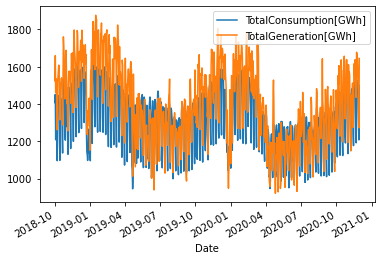

In [47]:
df[['TotalConsumption[GWh]','TotalGeneration[GWh]']].plot(legend=True)

<AxesSubplot:xlabel='Date'>

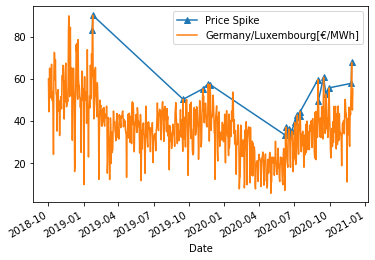

In [48]:
df[df['PriceSpike']]['Germany/Luxembourg[€/MWh]'].plot(marker='^',label='Price Spike', legend=True)
df['Germany/Luxembourg[€/MWh]'].plot(legend=True)

<AxesSubplot:xlabel='Date'>

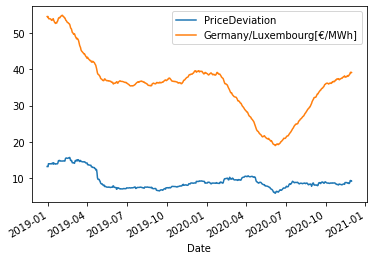

In [49]:
df['PriceDeviation'].plot(legend=True)
df['Germany/Luxembourg[€/MWh]'].rolling(window).mean().plot(legend=True)

<AxesSubplot:xlabel='Date'>

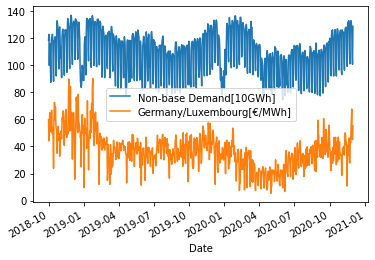

In [50]:
df[['Non-base Demand[10GWh]', 'Germany/Luxembourg[€/MWh]']].plot(legend=True)

<AxesSubplot:xlabel='Date'>

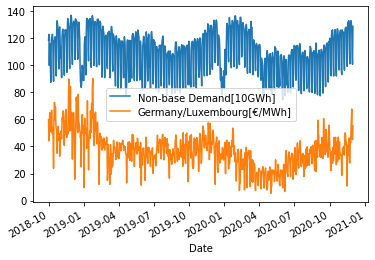

In [51]:
df[['Non-base Demand[10GWh]', 'Germany/Luxembourg[€/MWh]']].plot(legend=True)

<AxesSubplot:xlabel='Date'>

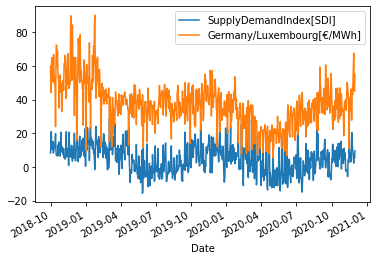

In [52]:
df[['SupplyDemandIndex[SDI]', 'Germany/Luxembourg[€/MWh]']].plot(legend=True)


<AxesSubplot:xlabel='TotalConsumption[GWh]', ylabel='Germany/Luxembourg[€/MWh]'>

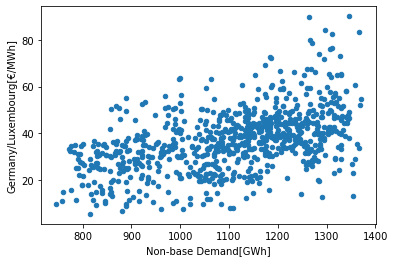

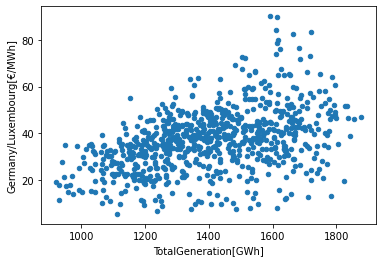

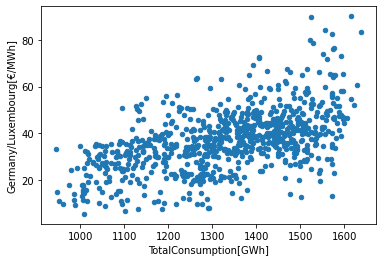

In [53]:
df.plot(kind='scatter', x='Non-base Demand[GWh]' ,y='Germany/Luxembourg[€/MWh]' )
df.plot(kind='scatter', x='TotalGeneration[GWh]' ,y='Germany/Luxembourg[€/MWh]' )
df.plot(kind='scatter', x='TotalConsumption[GWh]' ,y='Germany/Luxembourg[€/MWh]' )

In [54]:
df_normal = df[~df['PriceSpike']].copy()
df_normal.dropna(inplace=True)

<AxesSubplot:xlabel='Date'>

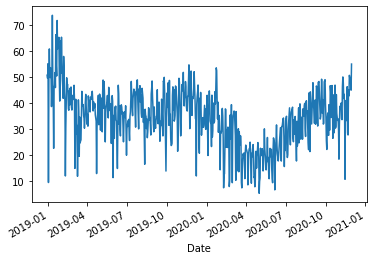

In [55]:
df_normal['Germany/Luxembourg[€/MWh]'].plot()

<Figure size 432x288 with 0 Axes>

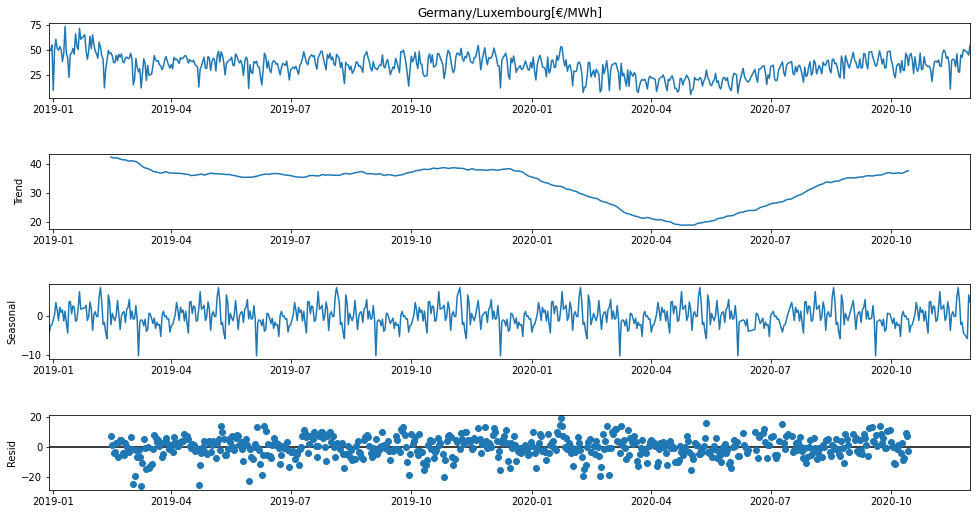

In [56]:
#Seasonal ARIMA model(SARIMA: Seasonal Auto Regressive Integrated Moving Average) with explanatory variables
decomposition = seasonal_decompose(df_normal['Germany/Luxembourg[€/MWh]'], period=window)
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

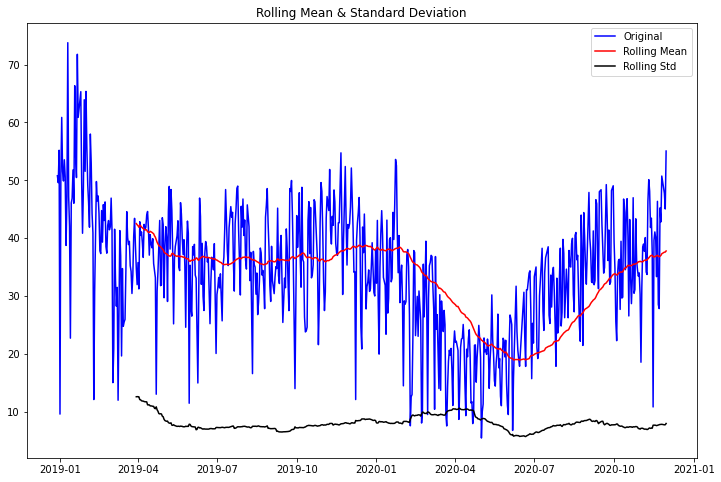

Results of Dickey-Fuller Test:
Test Statistic                  -2.471008
p-value                          0.122689
#Lags Used                      14.000000
Number of Observations Used    660.000000
Critical Value (1%)             -3.440297
Critical Value (5%)             -2.865929
Critical Value (10%)            -2.569107
dtype: float64


In [57]:
test_stationarity(df_normal['Germany/Luxembourg[€/MWh]'], window)

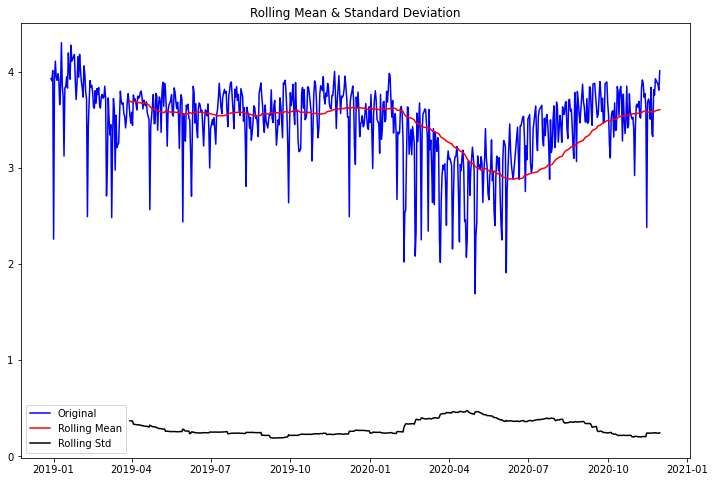

Results of Dickey-Fuller Test:
Test Statistic                  -2.112698
p-value                          0.239440
#Lags Used                      13.000000
Number of Observations Used    661.000000
Critical Value (1%)             -3.440282
Critical Value (5%)             -2.865922
Critical Value (10%)            -2.569104
dtype: float64


In [58]:
df_normal['log(Germany/Luxembourg[€/MWh])']= df_normal['Germany/Luxembourg[€/MWh]'].apply(lambda x: np.log(x))  
test_stationarity(df_normal['log(Germany/Luxembourg[€/MWh])'])
#Worse performance

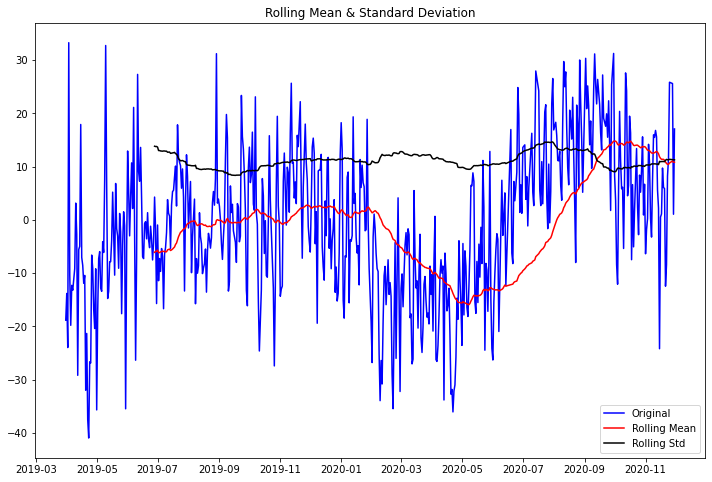

Results of Dickey-Fuller Test:
Test Statistic                  -2.566258
p-value                          0.100173
#Lags Used                      16.000000
Number of Observations Used    568.000000
Critical Value (1%)             -3.441915
Critical Value (5%)             -2.866642
Critical Value (10%)            -2.569487
dtype: float64


In [59]:
df_normal['seasonal_difference'] = df_normal['Germany/Luxembourg[€/MWh]'] - df_normal['Germany/Luxembourg[€/MWh]'].shift(window)  
test_stationarity(df_normal['seasonal_difference'].dropna(inplace=False))
#Much better performance

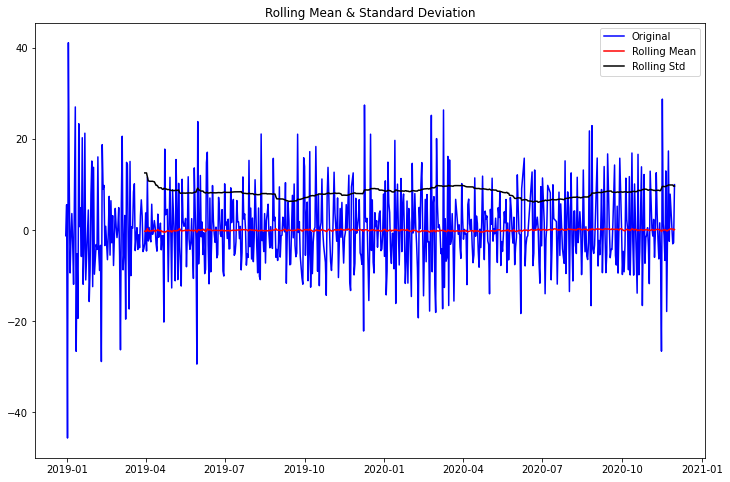

Results of Dickey-Fuller Test:
Test Statistic                -1.009250e+01
p-value                        1.112634e-17
#Lags Used                     1.300000e+01
Number of Observations Used    6.600000e+02
Critical Value (1%)           -3.440297e+00
Critical Value (5%)           -2.865929e+00
Critical Value (10%)          -2.569107e+00
dtype: float64


In [60]:
df_normal['first_difference'] = df_normal['Germany/Luxembourg[€/MWh]'] - df_normal['Germany/Luxembourg[€/MWh]'].shift(1)  
test_stationarity(df_normal['first_difference'].dropna(inplace=False))
#Very significant p-value
#Data normalised 

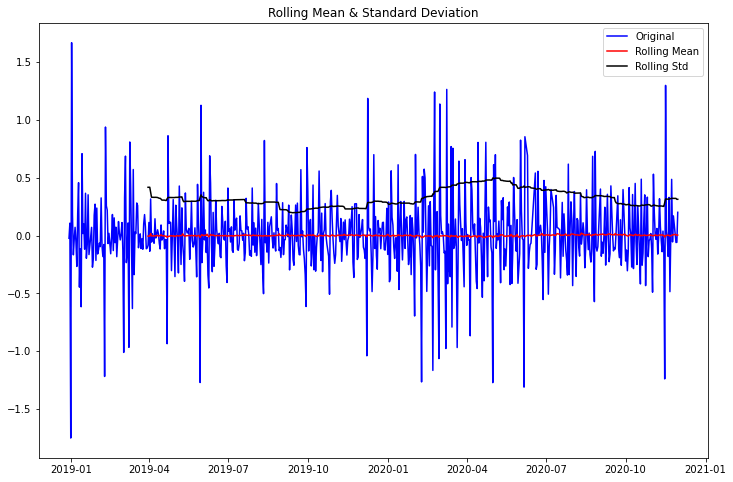

Results of Dickey-Fuller Test:
Test Statistic                -1.276760e+01
p-value                        7.895948e-24
#Lags Used                     1.200000e+01
Number of Observations Used    6.610000e+02
Critical Value (1%)           -3.440282e+00
Critical Value (5%)           -2.865922e+00
Critical Value (10%)          -2.569104e+00
dtype: float64


In [61]:
df_normal['first_difference_log']= df_normal['log(Germany/Luxembourg[€/MWh])'] - df_normal['log(Germany/Luxembourg[€/MWh])'].shift(1)
test_stationarity(df_normal['first_difference_log'].dropna(inplace=False))

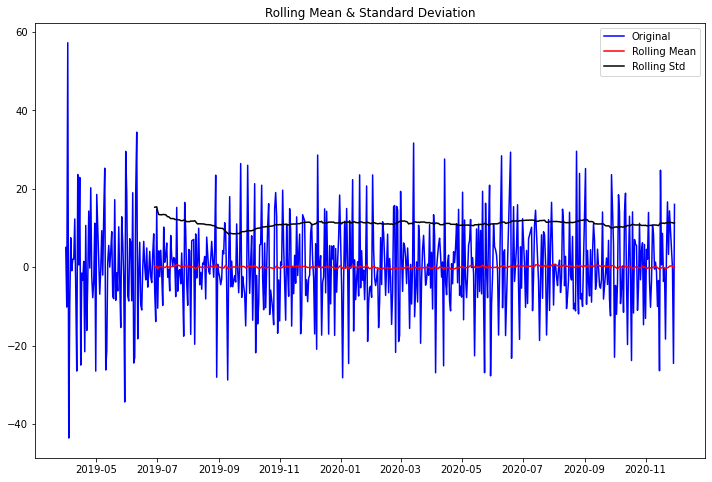

Results of Dickey-Fuller Test:
Test Statistic                -9.033505e+00
p-value                        5.365690e-15
#Lags Used                     1.300000e+01
Number of Observations Used    5.700000e+02
Critical Value (1%)           -3.441875e+00
Critical Value (5%)           -2.866624e+00
Critical Value (10%)          -2.569478e+00
dtype: float64


In [62]:
df_normal['seasonal_first_difference'] = df_normal['first_difference'] - df_normal['first_difference'].shift(window)  
test_stationarity(df_normal.seasonal_first_difference.dropna(inplace=False))
#Very Significant but not as much as the previous one

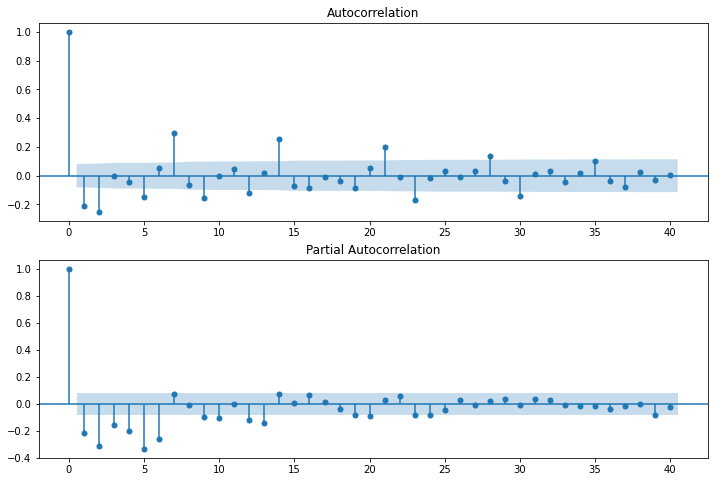

In [63]:
#Model Chosen 'first_difference'
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_normal['first_difference'].iloc[window+1:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_normal['first_difference'].iloc[window+1:], lags=40, ax=ax2)

In [74]:
try:
    df_normal = df_normal.asfreq('D')
    df_normal.index = pd.DatetimeIndex(df.index).to_period('D')
except:
    ar=1

#order, seasonal_order = gridsearch_sarima() 
    
#BEST PARAMETERS GRID_SEARCH
order_sarima = (1, 1, 1)
seasonal_order = (2, 1, 1, 7)    

mod_sarima = sm.tsa.statespace.SARIMAX(df_normal['Germany/Luxembourg[€/MWh]'], 
                                       order=order_sarima,
                                       seasonal_order=seasonal_order,
                                       trend='ct')
results_sarima = mod_sarima.fit(max_iter = 50, method = 'powell')
results_sarima.summary()


Optimization terminated successfully.
         Current function value: 3.141046
         Iterations: 10
         Function evaluations: 926


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:         Germany/Luxembourg[€/MWh]   No. Observations:                  703
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 7)   Log Likelihood               -2208.156
Date:                           Sun, 31 Jan 2021   AIC                           4432.311
Time:                                   15:42:53   BIC                           4468.662
Sample:                               12-29-2018   HQIC                          4446.368
                                    - 11-30-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0005      0.004     -0.115      0.908      -0.009       0.008
drift       5.289e-06   1.18e-05      0.450      0.653   -1.77e-05    2.83e-05
ar.L1          0.3240      0.043      7.479      0.000       0.239       0.409
ma.L1         -0.8901      0.027    -32.450      0.000      -0.944      -0.836
ar.S.L7        0.0766      0.040      1.926      0.054      -0.001       0.155
ar.S.L14       0.0562      0.039      1.440      0.150      -0.020       0.133
ma.S.L7       -0.9907      0.054    -18.265      0.000      -1.097      -0.884
sigma2        41.7903      2.507     16.670      0.000      36.877      46.704
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               203.83
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                            -0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Date'>

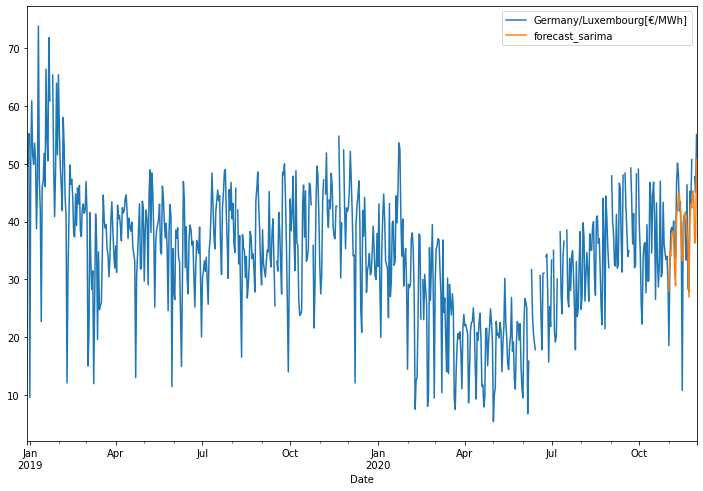

In [75]:
df_normal['forecast_sarima'] = results_sarima.predict(start = '2020-11-01', end= '2020-11-30') #,dynamic= True)  
df_normal['Germany/Luxembourg[€/MWh]'].dropna(inplace=True)
df_normal[['Germany/Luxembourg[€/MWh]', 'forecast_sarima']].plot(figsize=(12, 8))

In [76]:
#Set index to period Day
try:
    df_normal = df_normal.asfreq('D')
    df_normal.index = pd.DatetimeIndex(df.index).to_period('D')
except:
    ar=1
#To run the grid search, remove the # from the last line and run the next
#order =  gridsearch_arima() #1 to get the first difference
order_arima = (4, 1, 5)
mod_arima = sm.tsa.statespace.SARIMAX(df_normal['Germany/Luxembourg[€/MWh]'], trend='n', order=order_arima)
results_arima = mod_arima.fit()
results_arima.summary()

/home/cronos/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:     Germany/Luxembourg[€/MWh]   No. Observations:                  703
Model:                      SARIMAX(4, 1, 5)   Log Likelihood               -2253.372
Date:                       Sun, 31 Jan 2021   AIC                           4526.745
Time:                               15:42:58   BIC                           4572.284
Sample:                           12-29-2018   HQIC                          4544.346
                                - 11-30-2020                                         
Covariance Type:                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7711      0.016     48.379      0.000       0.740       0.802
ar.L2         -1.4236      0.013   -109.635      0.000      -1.449      -1.398
ar.L3          0.7850      0.013     58.789      0.000       0.759       0.811
ar.L4         -0.9593      0.014    -67.958      0.000      -0.987      -0.932
ma.L1         -1.3932      0.034    -40.472      0.000      -1.461      -1.326
ma.L2          1.7710      0.043     40.822      0.000       1.686       1.856
ma.L3         -1.6458      0.046    -36.091      0.000      -1.735      -1.556
ma.L4          1.2944      0.047     27.273      0.000       1.201       1.387
ma.L5         -0.5971      0.033    -18.109      0.000      -0.662      -0.532
sigma2        45.1629      1.674     26.979      0.000      41.882      48.444
===================================================================================
Ljung-Box (L1) (Q):                   2.39   Jarque-Bera (JB):               325.98
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                            -0.82
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Date'>

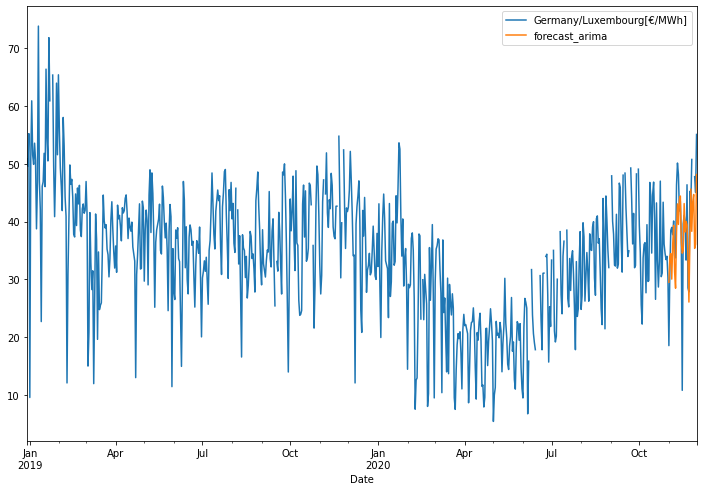

In [77]:
df_normal['forecast_arima'] = results_arima.predict(start = '2020-11-01', end= '2020-11-30')  # ,dynamic= True)  
df_normal['Germany/Luxembourg[€/MWh]'].dropna(inplace=True)
df_normal[['Germany/Luxembourg[€/MWh]', 'forecast_arima']].plot(figsize=(12, 8))

<AxesSubplot:xlabel='Date'>

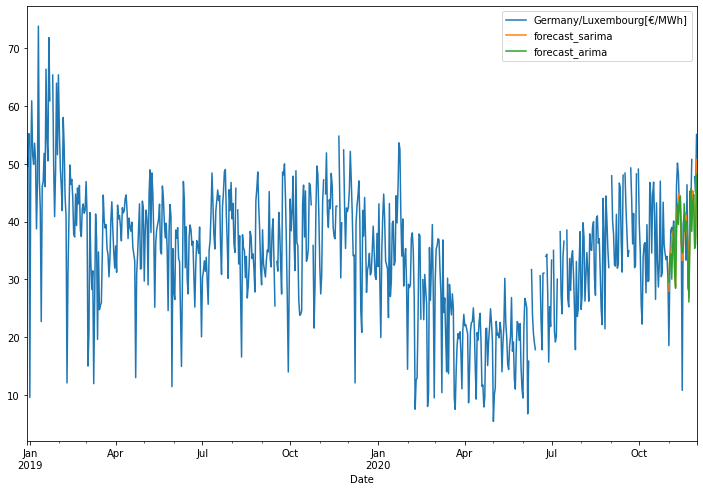

In [78]:
df_normal[['Germany/Luxembourg[€/MWh]', 'forecast_sarima', 'forecast_arima']].plot(figsize=(12, 8))

In [79]:
df_test['forecast_arima'] = results_arima.predict(start = '2020-12-01', end='2020-12-31')
df_test['forecast_sarima'] = results_sarima.predict(start = '2020-12-01', end='2020-12-31')
df_test

,Germany/Luxembourg[€/MWh],Denmark 1[€/MWh],TotalConsumption[GWh],Residual load[MWh],Biomass[GWh],Hydropower[GWh],Wind offshore[GWh],Wind onshore[GWh],Photovoltaics[GWh],Other renewable[GWh],Nuclear[GWh],Fossil brown coal[GWh],Fossil hard coal[GWh],Fossil gas[GWh],Hydro pumped storage[GWh],Other conventional[GWh],TotalGeneration[GWh],Non-base Demand[GWh],forecast_arima,forecast_sarima
Date,,,,,,,,,,,,,,,,,,,,
2020-12-01,57.650,57.650,1526.579,1328349,109.024,34.479,68.577,120.653,9.035,4.902,182.653,358.520,308.271,291.761,37.315,29.738,1554.928,1309.447,54.624971,50.498204
2020-12-02,80.345,79.410,1516.820,1400497,108.742,38.485,36.222,61.621,18.510,4.923,190.551,382.126,323.486,310.163,37.037,30.510,1542.376,1287.784,48.271758,50.138223
2020-12-03,48.730,31.315,1568.138,1083128,108.733,36.505,128.322,343.162,13.567,4.896,182.035,348.691,210.521,280.828,26.837,32.843,1716.940,1349.598,48.680506,49.509807
2020-12-04,40.560,20.035,1533.865,934678,108.809,33.120,129.650,448.114,21.450,4.892,178.690,330.163,156.882,243.057,24.128,35.397,1714.352,1322.055,51.770379,49.985603
2020-12-05,45.630,32.400,1296.998,1032943,109.402,30.662,57.254,182.747,24.084,4.861,194.616,359.754,180.181,260.524,18.889,35.143,1458.117,1071.720,44.876447,42.734788
2020-12-06,39.910,38.375,1201.126,952180,109.032,33.687,47.489,185.502,15.988,4.718,190.898,355.358,153.511,249.987,15.811,35.426,1397.407,976.541,41.577070,39.717459
2020-12-07,41.595,18.910,1496.525,1115878,108.641,35.668,99.411,263.794,17.464,4.785,185.742,367.366,236.979,276.184,26.590,35.602,1658.226,1275.115,50.880256,50.590663
2020-12-08,66.085,62.310,1517.775,1335322,108.964,35.444,29.964,119.413,33.102,4.808,195.721,389.569,312.077,293.148,23.576,36.300,1582.086,1286.610,54.375241,50.093289
2020-12-09,79.180,69.480,1514.338,1395978,108.725,37.284,40.869,69.060,8.461,4.845,195.847,388.178,335.774,315.895,34.108,38.173,1577.219,1281.207,47.849736,51.050436


In [80]:
#MSE: Mean Square Error
#MAE: Mean Absolute Error
#AMAPE: Adapted Mean Absolute Percentage Error

MSE_arima=np.sum((df_test['forecast_arima']-df_test['Germany/Luxembourg[€/MWh]'])**2)/df_test.shape[0]
MAE_arima=np.sum(np.abs((df_test['forecast_arima']-df_test['Germany/Luxembourg[€/MWh]'])))/df_test.shape[0]
MAPE_arima= np.sum((np.abs((df_test['forecast_arima']-df_test['Germany/Luxembourg[€/MWh]']))/df_test['Germany/Luxembourg[€/MWh]'])/df_test.shape[0])*100

MSE_sarima=np.sum((df_test['forecast_sarima']-df_test['Germany/Luxembourg[€/MWh]'])**2)/df_test.shape[0]
MAE_sarima=np.sum(np.abs((df_test['forecast_sarima']-df_test['Germany/Luxembourg[€/MWh]'])))/df_test.shape[0]
MAPE_sarima= np.sum((np.abs((df_test['forecast_sarima']-df_test['Germany/Luxembourg[€/MWh]']))/df_test['Germany/Luxembourg[€/MWh]'])/df_test.shape[0])*100


print('ARIMA MODEL: \n  MSE: {} \n  MAE: {} \n  MAPE: {} \n'.format(MSE_arima,MAE_arima,MAPE_arima))
print('SARIMA MODEL: \n  MSE: {} \n  MAE: {} \n  MAPE: {} \n'.format(MSE_sarima,MAE_sarima,MAPE_sarima))

ARIMA MODEL: 
  MSE: 193.36415167848932 
  MAE: 9.55340836378864 
  MAPE: 31.475968154443922 

SARIMA MODEL: 
  MSE: 198.21662586471126 
  MAE: 10.390272631689419 
  MAPE: 33.79932012473103 



<AxesSubplot:xlabel='Date'>

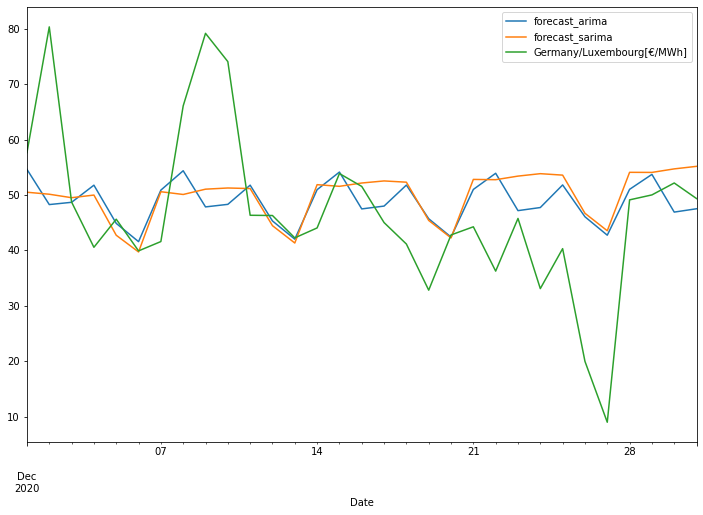

In [81]:
df_test[['forecast_arima','forecast_sarima', 'Germany/Luxembourg[€/MWh]']].plot(figsize=(12, 8))

In [82]:
df_test['Germany/Luxembourg[€/MWh]'].dropna(inplace=True)
df_test['residual_arima'] = df_test['Germany/Luxembourg[€/MWh]']- df_test['forecast_arima']
df_test['residual_sarima'] = df_test['Germany/Luxembourg[€/MWh]']- df_test['forecast_sarima']
df_test['residual_sarima'].dropna(inplace=True)
df_test['residual_arima'].dropna(inplace=True)

#Start the (G)arch Model
#Now we can fit the arch model using the best fit arima model parameters
p_ = order_arima[0]
o_ = order_arima[1]
q_ = order_arima[2]

# Using student T distribution usually provides better fit
garch_arima = arch_model(df_test['residual_arima'], p=p_, o=o_, q=q_  , dist='StudentsT')
res_garch_arima = garch_arima.fit(update_freq=5, disp='off')
print(res_garch_arima.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:               residual_arima   R-squared:                      -0.008
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.008
Vol Model:                        GJR-GARCH   Log-Likelihood:               -122.445
Distribution:      Standardized Student's t   AIC:                           270.890
Method:                  Maximum Likelihood   BIC:                           289.532
                                              No. Observations:                   31
Date:                      Sun, Jan 31 2021   Df Residuals:                       18
Time:                              15:43:01   Df Model:                           13
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -3

In [83]:
#Get Mean Arima
predicted_mu_arima = df_test['forecast_arima']
garch_arima_forecast = res_garch_arima.forecast(horizon=31, start='2020-12-01', method='simulation')

predicted_et_arima = garch_arima_forecast.mean['h.01'].iloc[-1]
# Combine both models' output: yt = mu + et
prediction_garch_arima = predicted_mu_arima + predicted_et_arima
df_test['prediction_garch_arima'] = prediction_garch_arima


In [84]:
#Now we can fit the arch model using the best fit sarima model parameters
p_ = order_sarima[0]
o_ = order_sarima[1]
q_ = order_sarima[2]

# Using student T distribution usually provides better fit
garch_sarima = arch_model(df_test['residual_sarima'], p=p_, o=o_, q=q_  , dist='StudentsT')
res_garch_sarima = garch_sarima.fit(update_freq=5, disp='off')

garch_sarima_forecast = res_garch_sarima.forecast(horizon=31, start='2020-12-01', method='simulation')

predicted_mu_sarima = df_test['forecast_sarima']
predicted_et_sarima = garch_sarima_forecast.mean['h.01'].iloc[-1]
# Combine both models' output: yt = mu + et
prediction_garch_sarima = predicted_mu_sarima + predicted_et_sarima
df_test['prediction_garch_sarima'] = prediction_garch_arima


print(res_garch_sarima.summary())


                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:              residual_sarima   R-squared:                      -0.001
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                        GJR-GARCH   Log-Likelihood:               -120.979
Distribution:      Standardized Student's t   AIC:                           253.958
Method:                  Maximum Likelihood   BIC:                           262.562
                                              No. Observations:                   31
Date:                      Sun, Jan 31 2021   Df Residuals:                       25
Time:                              15:43:02   Df Model:                            6
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -3

<AxesSubplot:xlabel='Date'>

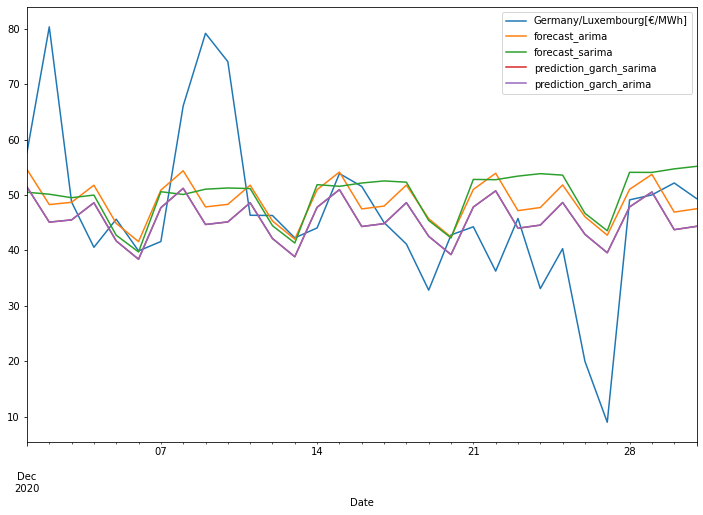

In [85]:
df_test[['Germany/Luxembourg[€/MWh]','forecast_arima','forecast_sarima', 'prediction_garch_sarima','prediction_garch_arima']].plot(figsize=(12, 8))

In [86]:
MSE_garch_arima=np.sum((df_test['prediction_garch_arima']-df_test['Germany/Luxembourg[€/MWh]'])**2)/df_test.shape[0]
MAE_garch_arima=np.sum(np.abs((df_test['prediction_garch_arima']-df_test['Germany/Luxembourg[€/MWh]'])))/df_test.shape[0]
MAPE_garch_arima= np.sum((np.abs((df_test['prediction_garch_arima']-df_test['Germany/Luxembourg[€/MWh]']))/df_test['Germany/Luxembourg[€/MWh]'])/df_test.shape[0])*100

MSE_garch_sarima=np.sum((df_test['prediction_garch_sarima']-df_test['Germany/Luxembourg[€/MWh]'])**2)/df_test.shape[0]
MAE_garch_sarima=np.sum(np.abs((df_test['prediction_garch_sarima']-df_test['Germany/Luxembourg[€/MWh]'])))/df_test.shape[0]
MAPE_garch_sarima= np.sum((np.abs((df_test['prediction_garch_sarima']-df_test['Germany/Luxembourg[€/MWh]']))/df_test['Germany/Luxembourg[€/MWh]'])/df_test.shape[0])*100

MSE_arima=np.sum((df_test['forecast_arima']-df_test['Germany/Luxembourg[€/MWh]'])**2)/df_test.shape[0]
MAE_arima=np.sum(np.abs((df_test['forecast_arima']-df_test['Germany/Luxembourg[€/MWh]'])))/df_test.shape[0]
MAPE_arima= np.sum((np.abs((df_test['forecast_arima']-df_test['Germany/Luxembourg[€/MWh]']))/df_test['Germany/Luxembourg[€/MWh]'])/df_test.shape[0])*100

MSE_sarima=np.sum((df_test['forecast_sarima']-df_test['Germany/Luxembourg[€/MWh]'])**2)/df_test.shape[0]
MAE_sarima=np.sum(np.abs((df_test['forecast_sarima']-df_test['Germany/Luxembourg[€/MWh]'])))/df_test.shape[0]
MAPE_sarima= np.sum((np.abs((df_test['forecast_sarima']-df_test['Germany/Luxembourg[€/MWh]']))/df_test['Germany/Luxembourg[€/MWh]'])/df_test.shape[0])*100


print('ARIMA MODEL: \n  MSE: {} \n  MAE: {} \n  MAPE: {} \n'.format(MSE_arima,MAE_arima,MAPE_arima))
print('SARIMA MODEL: \n  MSE: {} \n  MAE: {} \n  MAPE: {} \n'.format(MSE_sarima,MAE_sarima,MAPE_sarima))
print('GARCH ARIMA MODEL: \n  MSE: {} \n  MAE: {} \n  MAPE: {} \n'.format(MSE_garch_arima,MAE_garch_arima,MAPE_garch_arima))
print('GARCH SARIMA MODEL: \n  MSE: {} \n  MAE: {} \n  MAPE: {} \n'.format(MSE_garch_sarima,MAE_garch_sarima,MAPE_garch_sarima))

ARIMA MODEL: 
  MSE: 193.36415167848932 
  MAE: 9.55340836378864 
  MAPE: 31.475968154443922 

SARIMA MODEL: 
  MSE: 198.21662586471126 
  MAE: 10.390272631689419 
  MAPE: 33.79932012473103 

GARCH ARIMA MODEL: 
  MSE: 190.89331034450785 
  MAE: 9.534649396848183 
  MAPE: 29.42567937500239 

GARCH SARIMA MODEL: 
  MSE: 190.89331034450785 
  MAE: 9.534649396848183 
  MAPE: 29.42567937500239 



In [87]:
#Initialization NN

#SARIMAX-GARCH/ARMAX-GARCH model price prediction on day T;  
#historical price on day T-1; 
#historical price on day T-7; 
#historical price on day T-14; 
#non-base electricity demand on day T;  
#non-base electricity demand on day T-1.  

df_NN = df[['Germany/Luxembourg[€/MWh]','Non-base Demand[GWh]']]
df_NN['Germany/Luxembourg[€/MWh]T-1'] =  df_NN['Germany/Luxembourg[€/MWh]'].shift(1) 
df_NN['Germany/Luxembourg[€/MWh]T-7'] =  df_NN['Germany/Luxembourg[€/MWh]'].shift(7)
df_NN['Germany/Luxembourg[€/MWh]T-14'] =  df_NN['Germany/Luxembourg[€/MWh]'].shift(14)
df_NN['Non-base Demand[GWh]T-1'] =  df_NN['Non-base Demand[GWh]'].shift(1) 
  
# Combine both models' output: yt = mu + et
df_NN['Garch-Sarima Prediction'] = results_sarima.fittedvalues
df_NN.dropna(inplace=True, axis=0)
df_NN = df_NN[['Garch-Sarima Prediction','Germany/Luxembourg[€/MWh]','Non-base Demand[GWh]T-1', 'Germany/Luxembourg[€/MWh]T-14','Germany/Luxembourg[€/MWh]T-7','Germany/Luxembourg[€/MWh]T-1','Non-base Demand[GWh]']]


<ipython-input-87-0ef6db78f4c9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NN['Germany/Luxembourg[€/MWh]T-1'] =  df_NN['Germany/Luxembourg[€/MWh]'].shift(1)
<ipython-input-87-0ef6db78f4c9>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NN['Germany/Luxembourg[€/MWh]T-7'] =  df_NN['Germany/Luxembourg[€/MWh]'].shift(7)
<ipython-input-87-0ef6db78f4c9>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

QuantileTransformer()
QuantileTransformer()
QuantileTransformer()
QuantileTransformer()


/home/cronos/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2367: UserWarning: n_quantiles (1000) is greater than the total number of samples (526). n_quantiles is set to n_samples.
  warnings.warn("n_quantiles (%s) is greater than the total number "
/home/cronos/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2367: UserWarning: n_quantiles (1000) is greater than the total number of samples (176). n_quantiles is set to n_samples.
  warnings.warn("n_quantiles (%s) is greater than the total number "
/home/cronos/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2367: UserWarning: n_quantiles (1000) is greater than the total number of samples (526). n_quantiles is set to n_samples.
  warnings.warn("n_quantiles (%s) is greater than the total number "
/home/cronos/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2367: UserWarning: n_quantiles (1000) is greater than the total number of samples (176). n_quantile

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 50)                350       
_________________________________________________________________
dense_10 (Dense)             (None, 480)               24480     
_________________________________________________________________
dropout_1 (Dropout)          (None, 480)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 13)                6253      
_________________________________________________________________
dense_12 (Dense)             (None, 432)               6048      
_________________________________________________________________
dense_13 (Dense)             (None, 13)                5629      
_________________________________________________________________
dense_14 (Dense)             (None, 384)              

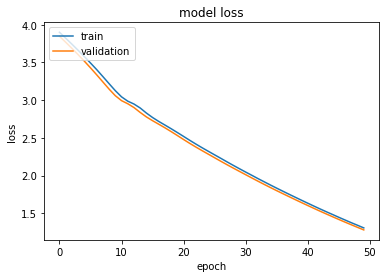

RUN PREDICTIONS ON VALIDATION DS
y-val mean: 36.119034090909096
predictions mean: 36.311497
mean squared error: 47.96199678889872
PLOT REAL VS PREDICTED FOR EACH SAMPLE


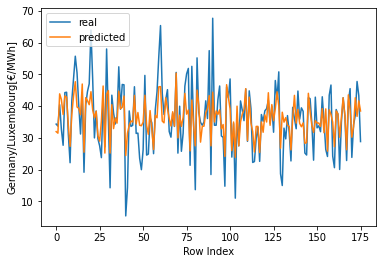

<Figure size 1440x576 with 0 Axes>

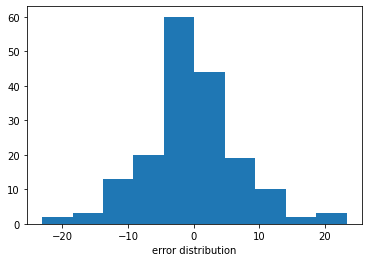

<Figure size 1440x576 with 0 Axes>

In [88]:
scaler_x, scaler_y, model = nn_model(df_NN)

In [89]:
df_test_NN = df_test[['Germany/Luxembourg[€/MWh]', 'Non-base Demand[GWh]', 'prediction_garch_sarima']]
df_test_NN = df_test_NN.append(df[['Germany/Luxembourg[€/MWh]', 'Non-base Demand[GWh]']].tail(14))
df_test_NN = df_test_NN.sort_index()
df_test_NN['Germany/Luxembourg[€/MWh]T-1'] =  df_test_NN['Germany/Luxembourg[€/MWh]'].shift(1) 
df_test_NN['Germany/Luxembourg[€/MWh]T-7'] =  df_test_NN['Germany/Luxembourg[€/MWh]'].shift(7)
df_test_NN['Germany/Luxembourg[€/MWh]T-14'] =  df_test_NN['Germany/Luxembourg[€/MWh]'].shift(14)
df_test_NN['Non-base Demand[GWh]T-1'] =  df_test_NN['Non-base Demand[GWh]'].shift(1) 
df_test_NN = df_test_NN['2020-12'][['Non-base Demand[GWh]', 'prediction_garch_sarima','Germany/Luxembourg[€/MWh]T-1','Germany/Luxembourg[€/MWh]T-7','Germany/Luxembourg[€/MWh]T-14','Non-base Demand[GWh]T-1']]


In [90]:
print(scaler_x.fit(df_test_NN))
xtest_scale = scaler_x.transform(df_test_NN)
predictions = model.predict(xtest_scale)
predictions = scaler_y.inverse_transform(predictions)
df_test_NN = df_test_NN.reset_index()
df_test_NN['PredictionsNN'] = predictions 
df_test_NN = df_test_NN.set_index('Date')

QuantileTransformer()


/home/cronos/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2367: UserWarning: n_quantiles (1000) is greater than the total number of samples (31). n_quantiles is set to n_samples.
  warnings.warn("n_quantiles (%s) is greater than the total number "


<AxesSubplot:xlabel='Date'>

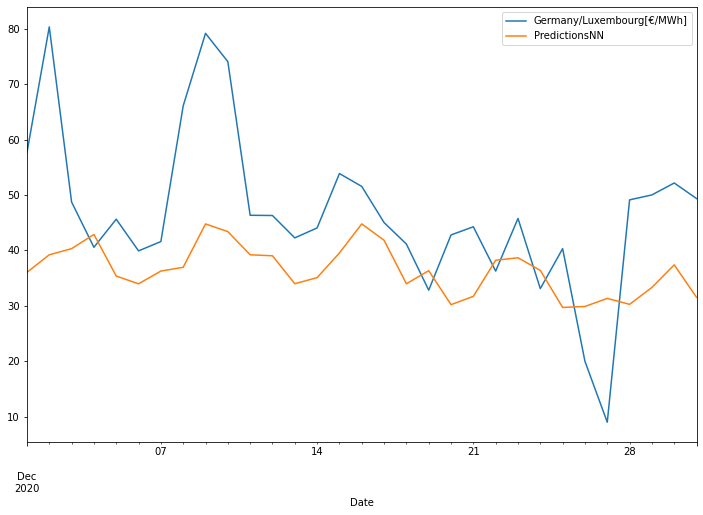

In [91]:
df_test['Germany/Luxembourg[€/MWh]'].plot(legend='Observed',figsize=(12, 8))
df_test_NN['PredictionsNN'].plot(legend='Estimated',figsize=(12, 8))